In [ ]:
import importlib
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

### Setup

Set the device. It uses an integer gpu_idx because at some point I may want to use distributed training and that needs a gpu id.

In [ ]:
gpu_idx = 0
device = torch.device(gpu_idx) if gpu_idx is not None else torch.device('cpu')

Command line arguments. Why command line? Because distributed does not like jupyter and at some point I will add distributed support.

In reality, args are going to be populated by experiment parameters, e.g. learning rate, or logging functions etc.

In [ ]:
import argparse

In [ ]:
parser = argparse.ArgumentParser(description='It is time for more... experiments.')
parser.add_argument('--batch_size', type=int, default=8, help='input batch size for training')
parser.add_argument('--num_workers', type=int, default=6, help='the number of dataloader workers')
args = parser.parse_args('')

### Model

Pick the model, i.e. import the relevant file and create the generator/discriminator networks:

In [ ]:
model_name = 'MSResNet'

In [ ]:
architecture = importlib.import_module('defocus.architecture.' + model_name)
G = architecture.Generator()
D = architecture.Discriminator()

Create the model, set everything. Why am I setting the optimizer inside the model? Because optimizers depend on the model parameters - seemed more reasonable.

In [ ]:
from defocus.model import Model

In [ ]:
model = Model()
model.G = G
model.D = D
# model.use_perceptual()
model.set_G_optimizer('AdamP')
model.set_D_optimizer('AdamP')

But why set the losses as part of the model? Because I can't think of them separately, a GAN is its parameters _and_ its loss.

Also note that we can set the weights if we are using multiple losses.

In [ ]:
model.set_resconstruction_loss(loss_functions=[nn.L1Loss()], 
                               weights=[1.0])
model.set_adversarial_loss(loss_functions=[nn.BCEWithLogitsLoss()],
                           weights=[1.0])
# model.set_perceptual_loss(loss_functions=[nn.L1Loss()],
#                           weights=[1.0])

### Data

Again, import the relevant dataset. For example, MSResNet requires a mipmap (image pyramid) as input.

In [ ]:
data = importlib.import_module('defocus.data.' + model_name)
train_dataset = data.Dataset(root_folder='/storage/projects/all_datasets/GOPRO/train/', 
                             image_pair_list='/storage/projects/all_datasets/GOPRO/train/train_image_pair_list.txt',
                            )

And the dataloader. Why am I using the Sampler stuff? Because distributed blabla.

In [ ]:
from torch.utils.data import SequentialSampler, RandomSampler, DataLoader

In [ ]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=args.batch_size,
                          shuffle=False,
                          sampler=RandomSampler(train_dataset, replacement=False),
                          num_workers=args.num_workers,
                          pin_memory=True,
                          drop_last=True,
                         )

... and the training loop. Note that there is only the bare minimum bookkeeping, no validation loop, no mixed precision. This is just the skeleton training code.

Actual training implementation is in the Trainer class.

### Evaluation

In [ ]:
model = Model()
model.G = architecture.Generator()
model.D = architecture.Discriminator()
model.set_G_optimizer('AdamP')
model.set_D_optimizer('AdamP')
# model.load('19072020-doublegpu_bs_8/epoch_50.pth')
model.load('14072020-singlegpu_bs_8_epoch_50.pth')
# model.load('epoch_75.pth')
# model.load('17072020-doublegpu_bs_16/epoch_60.pth')
model2 = Model()
model2.G = architecture.Generator()
model2.D = architecture.Discriminator()
model2.set_G_optimizer('AdamP')
model2.set_D_optimizer('AdamP')
# model2.load('19072020-doublegpu_bs_8/epoch_60.pth')
model2.load('epoch_50.pth')

In [ ]:
device2 = torch.device(1)

In [ ]:
device = torch.device('cpu')
device2 = torch.device('cpu')

In [ ]:
model.to(device);
model2.to(device2);

In [ ]:
data = importlib.import_module('defocus.data.' + model_name)
val_dataset = data.Dataset(root_folder='/storage/projects/all_datasets/GOPRO/train/', 
                           image_pair_list='/storage/projects/all_datasets/GOPRO/train/val_image_pair_list.txt',
#                            mode='test',
                          )

In [ ]:
from torch.utils.data import SequentialSampler, RandomSampler, DataLoader

In [ ]:
val_loader = DataLoader(dataset=val_dataset,
                          batch_size=1,
                          shuffle=False,
                          sampler=RandomSampler(val_dataset, replacement=False),
                          num_workers=args.num_workers,
                          pin_memory=True,
                          drop_last=True,
                         )

In [ ]:
import random

20299


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


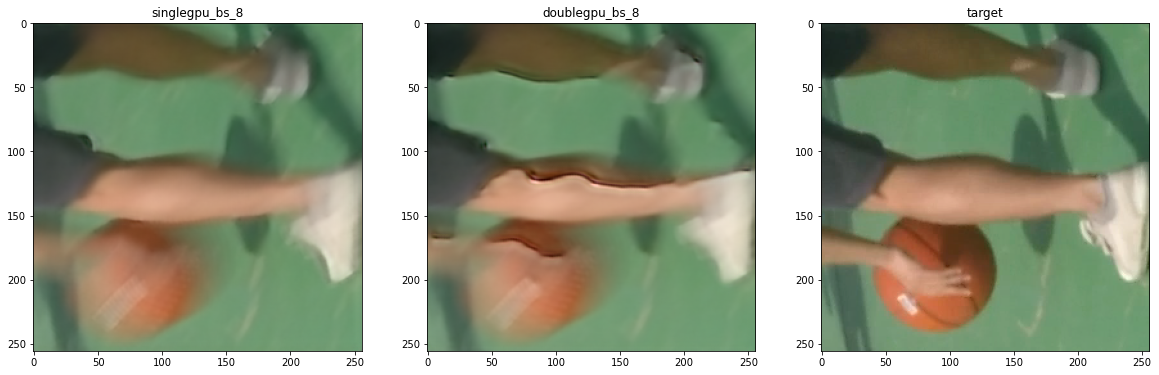

In [ ]:
# seed=243948394
# seed=986896 # double better
# seed=675 # single better
seed = random.randint(0, 238782)
# seed=21237
print(seed)
random.seed(seed)
torch.manual_seed(seed)
for sample in val_loader:
    input_ = [data.to(device) for data in sample['input']]
    target = [data.to(device) for data in sample['target']]
    input_2 = [data.to(device2) for data in sample['input']]
    target2 = [data.to(device2) for data in sample['target']]
    break
with torch.no_grad():
    output = model.G(input_)
    output2 = model2.G(input_2)
    
inp1 = input_[-1][0].detach().cpu().numpy().transpose(1,2,0)
out1 = output[-1][0].detach().cpu().numpy().transpose(1,2,0)
trg1 = target[-1][0].detach().cpu().numpy().transpose(1,2,0)
inp2 = input_2[-1][0].detach().cpu().numpy().transpose(1,2,0)
out2 = output2[-1][0].detach().cpu().numpy().transpose(1,2,0)
trg2 = target2[-1][0].detach().cpu().numpy().transpose(1,2,0)
plt.figure(figsize=(20,20))

# plt.subplot(321)
# plt.title('input')
# plt.imshow(inp1/255)
# plt.subplot(322)
# plt.title('input2')
# plt.imshow(inp2/255)

# plt.subplot(323)
plt.subplot(131)
plt.title('singlegpu_bs_8')
plt.imshow(out1/255)
# plt.subplot(324)
plt.subplot(132)
plt.title('doublegpu_bs_8')
plt.imshow(out2/255)
plt.subplot(133)
plt.title('target')
plt.imshow(trg1/255)
plt.savefig('multigpu_compare/seed_{}.png'.format(seed))

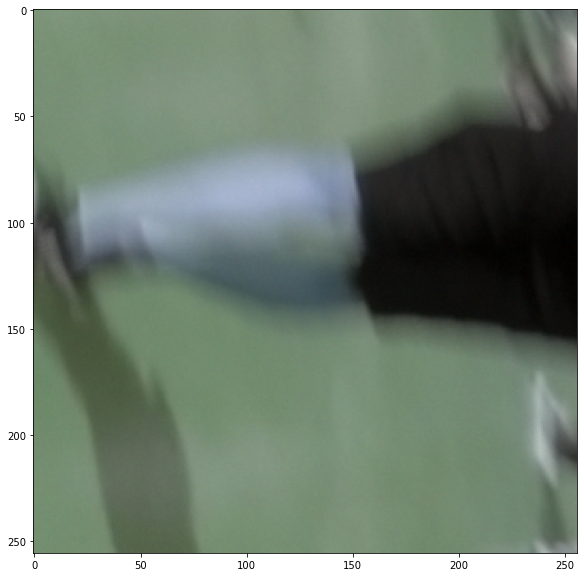

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(inp1/255)

### Results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


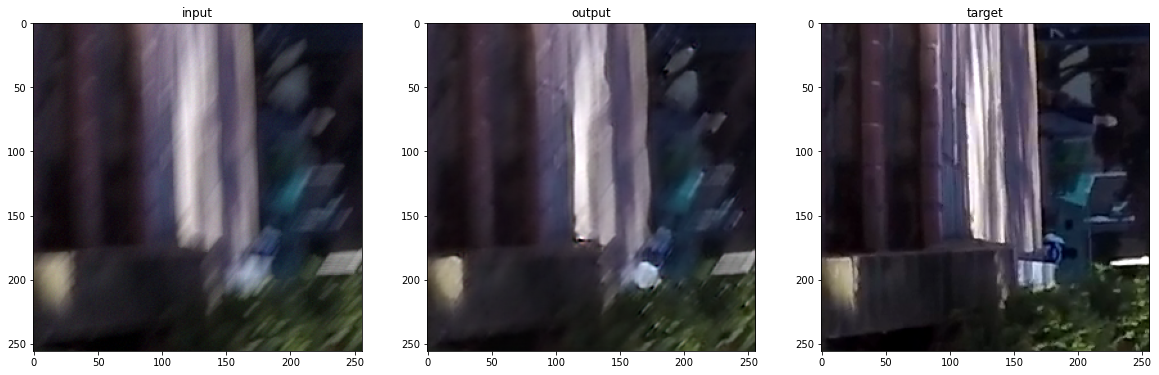

In [ ]:
for sample in train_loader:
    input_ = [data.to(device) for data in sample['input']]
    target = [data.to(device) for data in sample['target']]
    break
with torch.no_grad():
    output = model.G(input_)
inp = input_[-1][0].detach().cpu().numpy().transpose(1,2,0)
out = output[-1][0].detach().cpu().numpy().transpose(1,2,0)
trg = target[-1][0].detach().cpu().numpy().transpose(1,2,0)
plt.figure(figsize=(20,10))
plt.subplot(131)
plt.title('input')
plt.imshow(inp/255)
plt.subplot(132)
plt.title('output')
plt.imshow(out/255)
plt.subplot(133)
plt.title('target')
plt.imshow(trg/255)

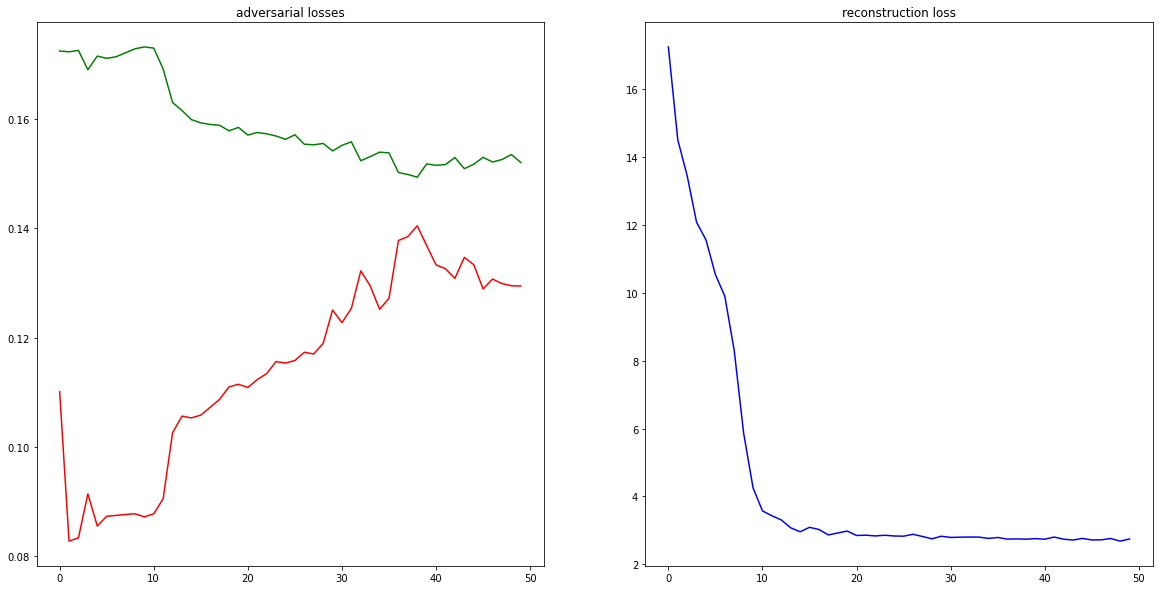

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.title('adversarial losses')
plt.plot(g_adv_losses, 'r')
plt.plot(d_losses, 'g')
plt.subplot(122)
plt.title('reconstruction loss')
plt.plot(g_rec_losses, 'b')

### Data leakage

Note that GOPRO dataset has leakage.

Check this:

Test sequences: _384_, _385_, 396, 410, 854, 862, _868_, _869_, _871_, _881_

Train sequences: 372, 374, 378, 379, 380, _384_, _385_, 386, 477, 857, _868_, _871_, 881, 884

Some sequences are just part of the same video, i.e. same person/car/wall is seen in both train and test sets.

__TODO__: Replace sequences 384, 385, 868, 869, 881 in test with 372, 374, 477 from the train folder.

Here I have split the leaky dataset's train part to val/train. Again, currently it has
# __!!! LEAKAGE !!!__